In [1]:
save_folder = '/home/jtauber/Documents/MillerData/analysis2/lfp/spectral/coherence/total_coherence/figures/'
save_figs = False

In [2]:
from pap.view import get_colors
from pap.utils import pickle_open
from pap.view import plot_spectrogram
import neural_analysis as na

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
import statsmodels.stats.multitest as mt
import scipy.stats as st

import seaborn as sns
sns.set()
sns.set_style('ticks')
sns.set_context('talk')

In [3]:
areas = ['CPB', '7b', 'FEF', 'vlPFC']

area_pairs = np.array([['CPB', '7b'],
       ['CPB', 'FEF'],
       ['CPB', 'vlPFC'],
       ['7b', 'FEF'],
       ['7b', 'vlPFC'],
       ['FEF', 'vlPFC']])

area_pairs_dict = {}
for i in range(len(area_pairs)):
    name = area_pairs[i][0] + '-' + area_pairs[i][1]
    area_pairs_dict[name] = area_pairs[i]

In [4]:
all_results_jones = pickle_open('jones_total_coherence_400_fw4.pickle')
all_results_mary = pickle_open('mary_total_coherence_400_fw4.pickle')

all_results = xr.concat([all_results_mary, all_results_jones], dim='session')

all_results_jones_z = pickle_open('jones_total_coherence_400_fw4_z.pickle')
all_results_mary_z = pickle_open('mary_total_coherence_400_fw4_z.pickle')

all_results_z = xr.concat([all_results_mary_z, all_results_jones_z], dim='session')

In [5]:
all_results.coords

Coordinates:
  * cond       (cond) <U5 'awake' 'drug2'
  * area_pair  (area_pair) <U9 'CPB-7b' 'CPB-FEF' ... '7b-vlPFC' 'FEF-vlPFC'
  * stim       (stim) <U9 'tone_only' 'cpt_tone' 'puff_only'
  * freqs      (freqs) float64 5.0 7.5 10.0 12.5 15.0 ... 82.5 85.0 87.5 90.0
  * timepts    (timepts) float64 0.2 0.25 0.3 0.35 0.4 ... 2.6 2.65 2.7 2.75 2.8
  * session    (session) object '0809' '0818' '0822' ... '0206' '0210' '0301'

In [6]:
areas_ord = ['CPB', '7b', 'FEF', 'vlPFC']
conv_label = {'vlPFC': 'PFC',
              'FEF': '8A',
              'CPB': 'STG',
              '7b': 'PPC'}
name_conv = {'tone_only': 'Tone 1',
             'puff_only': 'UC Puff',
             'cpt_tone': 'Tone 2',
             'cpt_puff': 'C Puff'}

In [7]:
freq = all_results.freqs.data
timepts = all_results.timepts.data

In [8]:
# timepts = np.array([0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65,
#        0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 , 1.15, 1.2 ,
#        1.25, 1.3 , 1.35])
# trial_length = timepts.size

In [9]:
change_results = all_results.copy()

In [10]:
sids = change_results.session.data
phases = change_results.cond.data
areas = change_results.area_pair.data
stims = change_results.stim.data

for sid in sids:
    for phase in phases:
        for area in areas:
            for stim in stims:
                raw_data = all_results.loc[sid,phase,area,stim,:,:].data
                baseline = raw_data[:,:4].mean(1)[:,None]
                change = (raw_data - baseline) 
            
                change_results.loc[sid,phase,area,stim,:,:] = change


In [11]:
change_results_z = all_results_z.copy()

In [12]:
sids = change_results_z.session.data
phases = change_results_z.cond.data
areas = change_results_z.area_pair.data
stims = change_results_z.stim.data

for sid in sids:
    for phase in phases:
        for area in areas:
            for stim in stims:
                raw_data = all_results_z.loc[sid,phase,area,stim,:,:].data
                baseline = raw_data[:,:4].mean(1)[:,None]
                change = (raw_data - baseline) 
            
                change_results_z.loc[sid,phase,area,stim,:,:] = change

In [13]:
freq = change_results.freqs.data
timepts = change_results.timepts.data

In [31]:
areas_ord = ['CPB', '7b', 'FEF', 'vlPFC']
conv_label = {'vlPFC': 'PFC',
              'FEF': '8A',
              'CPB': 'STG',
              '7b': 'PPC'}
name_conv = {'tone_only': 'UC Tone',
             'puff_only': 'UC Puff',
             'cpt_tone': 'C Tone - Puff',
             'cpt_puff': 'C Puff'}

In [32]:
def cut_spec(spec, freq, cut_low, cut_high):
    cut_ind_high = np.where(freq <= cut_high)[0][-1] + 1
    cut_ind_low = np.where(freq >= cut_low)[0][0]
    
    if spec.ndim == 2:
        return spec[cut_ind_low:cut_ind_high,:], freq[cut_ind_low:cut_ind_high]
    if spec.ndim == 3:
        return spec[:,cut_ind_low:cut_ind_high,:], freq[cut_ind_low:cut_ind_high]

In [33]:
timepts_orig = all_results.timepts.data
timepts = timepts_orig - 0.5
def plot_coh_stim_msrp_vert(stim, cut_low, cut_high):
    fwer = 0.05
    cmin = -0.5
    cmax = 0.5
    
    phases = ['awake', 'drug2']
    
    conv_phase = {'awake': 'Awake',
              'drug2': 'Unconscious'}
    
    fig = plt.figure(constrained_layout=True, figsize=(16,16))
    widths = [2, 2, 2]
    heights = [1, 1, 1, 1, 1, 1]
    gs = fig.add_gridspec(ncols=3, nrows=6, width_ratios=widths,
                              height_ratios=heights)

    label_fontsize = 24
    tick_fontsize = 20
    
    freq_orig = change_results.freqs.data
    
    for i in range(6):
        pair_name = change_results.area_pair.data[i]
        pair = area_pairs_dict[pair_name]
        a1 = pair[0]
        a2 = pair[1]
        
        label_a1 = conv_label[a1]
        label_a2 = conv_label[a2]
        for j, phase in enumerate(phases):
            
            coh = change_results.loc[:,phase,pair_name,stim,:,:].mean('session')
            coh, freq = cut_spec(coh, freq_orig, cut_low, cut_high)
            
            coh_stats = change_results.loc[:,phase,pair_name,stim,:,:]
            coh_stats, freq = cut_spec(coh_stats, freq_orig, cut_low, cut_high)
            # todo move me out
            a = coh_stats.shape[1]
            b = coh_stats.shape[2]
            reshape = (a,b)
            
            # baseline comparison stats
            phase_ttest = st.ttest_1samp(coh_stats, 0)
            phase_pvals = phase_ttest.pvalue
            phase_pvals_flat = phase_pvals.flatten()
            fdr, pvals = mt.fdrcorrection(phase_pvals_flat, alpha=fwer)
            fdr_phase = np.reshape(fdr, reshape)
#             print(reshape)
#             print(fdr_phase.shape)
            
            ax = fig.add_subplot(gs[i, j])
            im = plot_spectrogram(timepts, freq, coh, cmap='coolwarm', clim=[cmin,cmax], ax=ax)
            ax.contour(timepts, freq, fdr_phase, levels=[0.5], colors=[[0,0,0]], linewidths=0.35)
            
            ax.vlines(0, -1, 60, linewidth=6, alpha=0.4)
            ax.set_ylim([cut_low,60])

            if j != 0:
                ax.get_yaxis().set_ticks([])

            if i != 5:
                ax.get_xaxis().set_ticks([])
                
            if i == 5:
                ax.set_xlabel('Time (sec)', fontsize=label_fontsize, fontweight='bold')

            ax.tick_params(axis='both', labelsize=tick_fontsize)
            
            if i == 0:
                ax.set_title(conv_phase[phase], fontsize=label_fontsize, fontweight='bold')
            if j == 0:
                ax.set_ylabel(f'{label_a1} - {label_a2}\nFreq (Hz)', fontsize=label_fontsize, fontweight='bold')
    #         label = 'Width: {}\nHeight: {}'.format(widths[j], heights[i])
    for i in range(6):
        pair_name = change_results.area_pair.data[i]
        pair = area_pairs_dict[pair_name]
        a1 = pair[0]
        a2 = pair[1]
        
        label_a1 = conv_label[a1]
        label_a2 = conv_label[a2]
        
        awake_mean = change_results.loc[:,'awake',pair_name,stim,:,:].mean('session')
        drug_mean = change_results.loc[:,'drug2',pair_name,stim,:,:].mean('session')
        
        awake_mean, _ = cut_spec(awake_mean, freq_orig, cut_low, cut_high)
        drug_mean, _ = cut_spec(drug_mean, freq_orig, cut_low, cut_high)
        
        n_sessions = change_results_z.session.data.size
        stats_awake = change_results_z.loc[:,'awake',pair_name,stim,:,:].data
        stats_drug = change_results_z.loc[:,'drug2',pair_name,stim,:,:].data
        
        stats_awake, _ = cut_spec(stats_awake, freq_orig, cut_low, cut_high)
        stats_drug, _ = cut_spec(stats_drug, freq_orig, cut_low, cut_high)
# #         print(stats_awake.shape)
        
        ttest = stats.ttest_rel(stats_awake, stats_drug, axis=0)
        

        
        pvals_flat = ttest.pvalue.flatten()
        fdr, pvals = mt.fdrcorrection(pvals_flat, alpha=fwer)
        fdr_rs = np.reshape(fdr, reshape)
# #         print(fdr_rs.shape)
# #         print(awake_mean.shape)
        
        ax = fig.add_subplot(gs[i, 2])
        im = plot_spectrogram(timepts, freq, drug_mean - awake_mean, cmap='PRGn', clim=[cmin,cmax], ax=ax)
        ax.contour(timepts, freq, fdr_rs, levels=[0.5], colors=[[0,0,0]], linewidths=0.35)
        ax.vlines(0, -1, 60, linewidth=6, alpha=0.4)
        ax.set_ylim([cut_low,60])
        
        ax.get_yaxis().set_ticks([])

        if i != 5:
            ax.get_xaxis().set_ticks([])

        if i == 5:
            ax.set_xlabel('Time (sec)', fontsize=label_fontsize, fontweight='bold')

        ax.tick_params(axis='both', labelsize=tick_fontsize)

        if i == 0:
            ax.set_title('Unconscious - Awake', fontsize=label_fontsize, fontweight='bold')
        
    fig.suptitle(name_conv[stim], fontsize=32, fontweight='bold');

<ipython-input-33-e27d0edacf49>:55: UserWarning: No contour levels were found within the data range.
  ax.contour(timepts, freq, fdr_phase, levels=[0.5], colors=[[0,0,0]], linewidths=0.35)
<ipython-input-33-e27d0edacf49>:55: UserWarning: No contour levels were found within the data range.
  ax.contour(timepts, freq, fdr_phase, levels=[0.5], colors=[[0,0,0]], linewidths=0.35)
<ipython-input-33-e27d0edacf49>:55: UserWarning: No contour levels were found within the data range.
  ax.contour(timepts, freq, fdr_phase, levels=[0.5], colors=[[0,0,0]], linewidths=0.35)
<ipython-input-33-e27d0edacf49>:55: UserWarning: No contour levels were found within the data range.
  ax.contour(timepts, freq, fdr_phase, levels=[0.5], colors=[[0,0,0]], linewidths=0.35)
<ipython-input-33-e27d0edacf49>:55: UserWarning: No contour levels were found within the data range.
  ax.contour(timepts, freq, fdr_phase, levels=[0.5], colors=[[0,0,0]], linewidths=0.35)
<ipython-input-33-e27d0edacf49>:55: UserWarning: No con

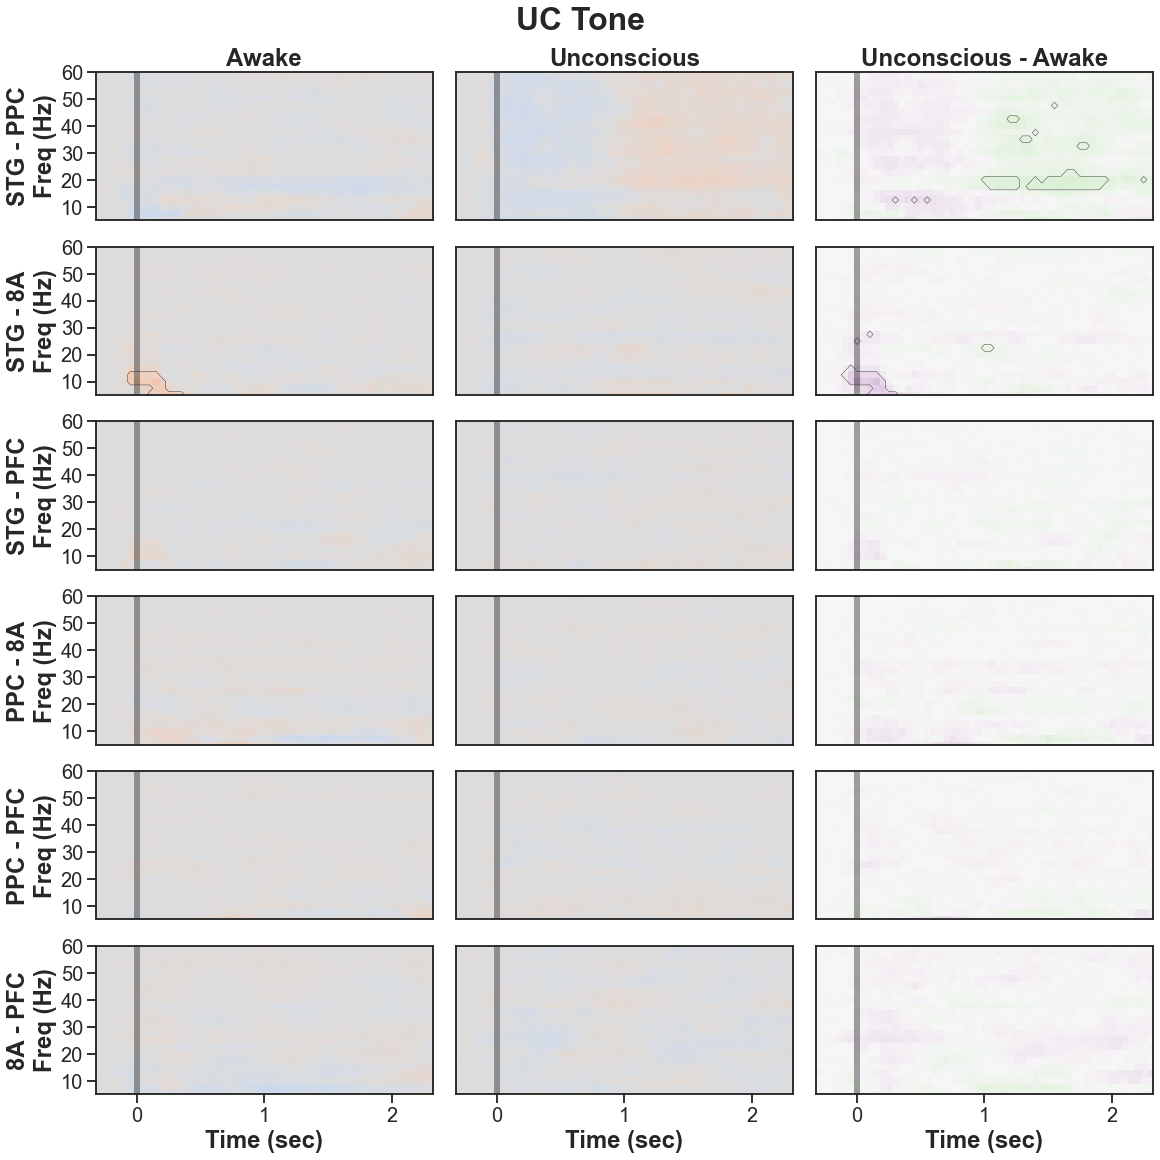

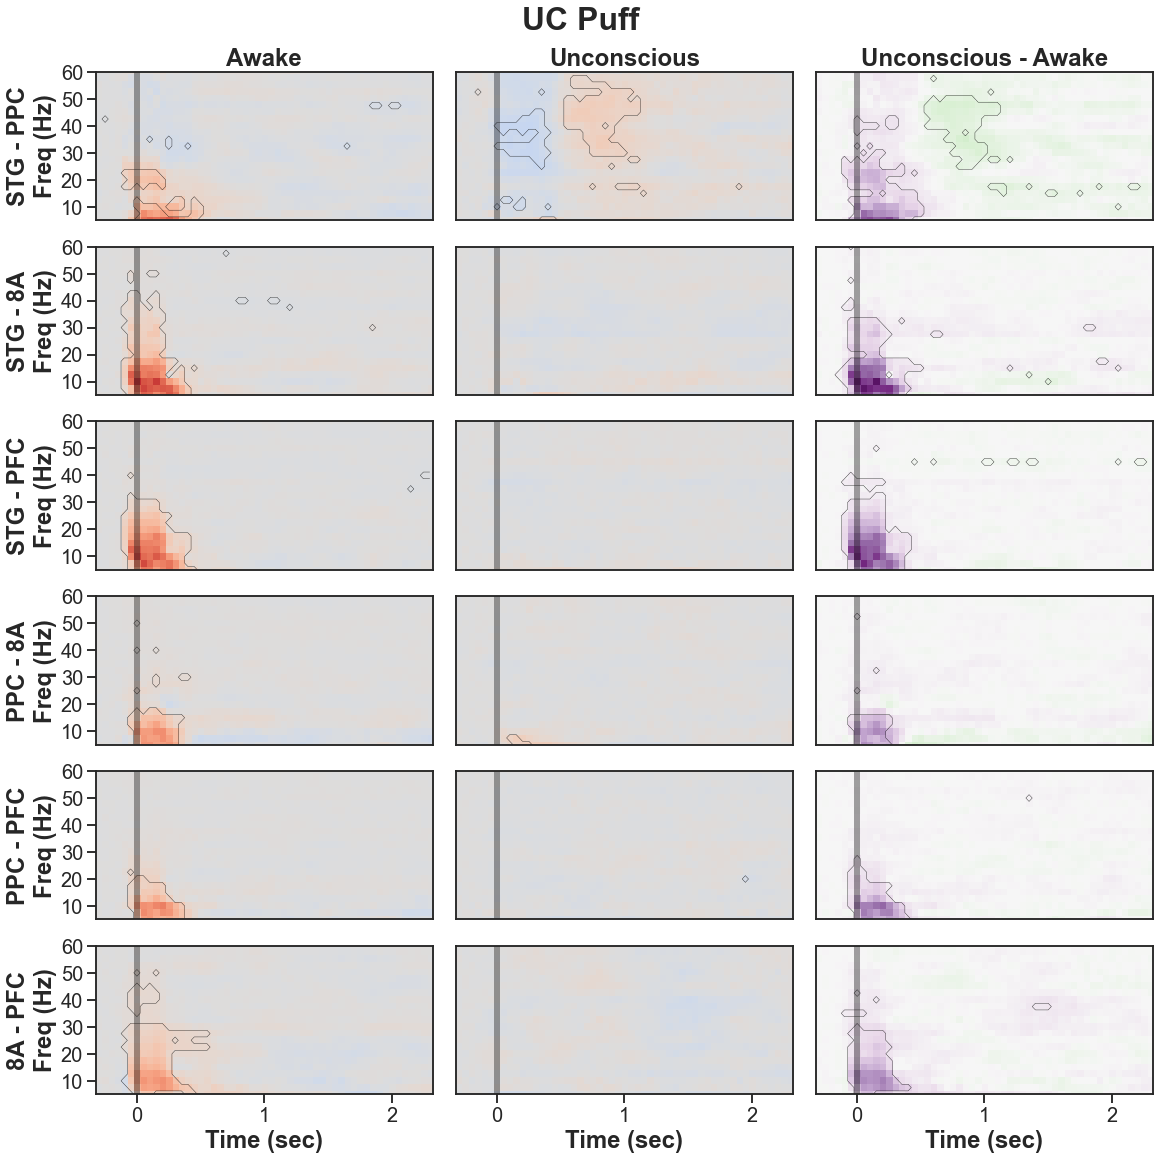

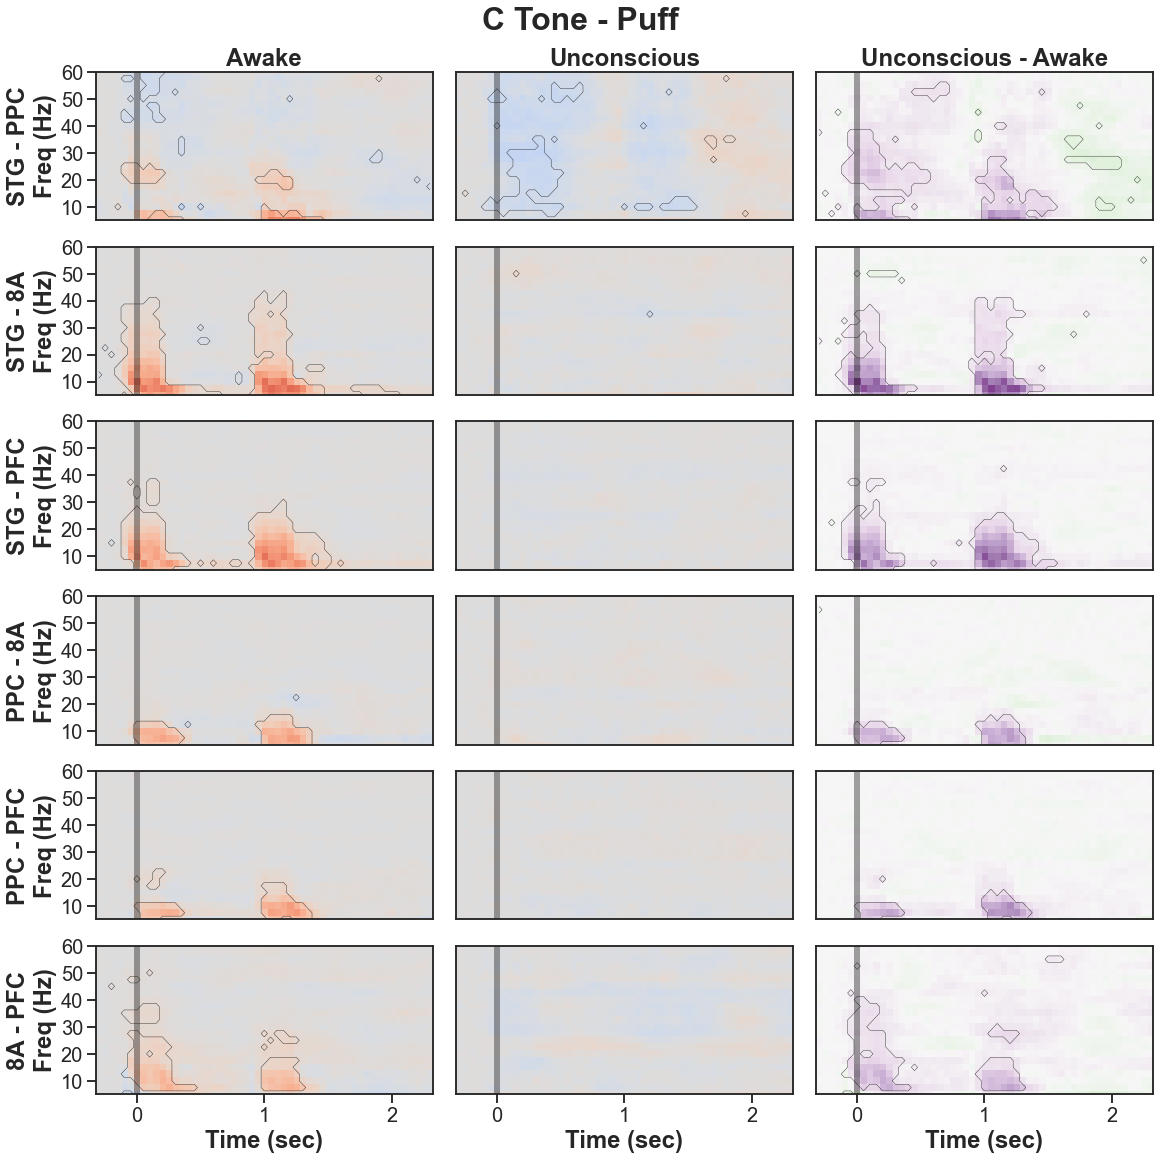

In [34]:
stim_plots = ['tone_only', 'puff_only', 'cpt_tone']

for stim in stim_plots:
    plot_coh_stim_msrp_vert(stim, 5, 60)
    if save_figs == True:
        plt.savefig(f'{save_folder}/total_coh_{stim}', dpi=300)

In [55]:
def plot_colorbar():
    
    fig, ax = plt.subplots(figsize=(10,2))
    
    low = -0.5
    high = 0.5
    
    area = 'CPB'
    pair_name = 'CPB-7b'
    stim = 'tone_only'

    
    coh = change_results.loc[pair_name,:,:,stim,phase,:].mean('session')

    im = plot_spectrogram(timepts - 0.5, freq, coh, cmap='coolwarm', clim=[low, high])

    fig.colorbar(im, ax, orientation='horizontal')
    ax.set_title(r'Coherence change from baseline', size='30', weight='bold')
    fig.tight_layout()

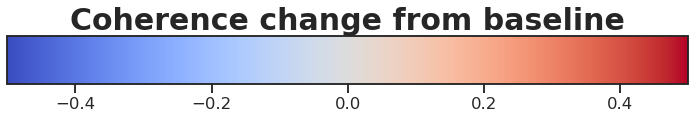

In [13]:
plot_colorbar()
# plt.savefig('coh_colorbar.png', dpi=300)

In [20]:
def plot_colorbar_stats():
    
    fig, ax = plt.subplots(figsize=(10,2))
    
    low = -0.5
    high = 0.5
    
    area = 'CPB'
    pair_name = 'CPB-7b'
    stim = 'tone_only'

    
    coh = change_results.loc[pair_name,:,:,stim,phase,:].mean('session')

    im = plot_spectrogram(timepts - 0.5, freq, coh, cmap='PRGn', clim=[low, high])

    fig.colorbar(im, ax, orientation='horizontal')
    ax.set_title(r'Coherence change (propofol - awake)', size='30', weight='bold')
    fig.tight_layout()

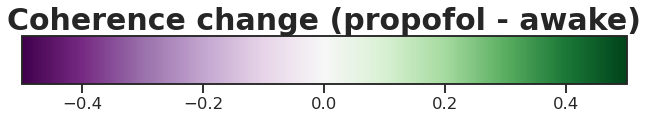

In [23]:
plot_colorbar_stats()
plt.savefig('coh_colorbar_stats.png', dpi=300)